# **CS 235 - Data Mining Techniques**

Team Members -

1.   **Aryan Ramachandra**, Student ID - **862545919**
2.   **Saransh Gupta**, Student ID - **862548920**




## **Installing Libraries**


This line installs the UC Irvine dataset Library into the notebook. This ensures that the dataset can be downloaded directly into the notebook. Thus making the file run on any python environment.

### **References**

[UCIrvine](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) - to download and import the dataset directly into the notebook and also some syntax to extract features and the target class in the dataset.

In [3]:
!pip install ucimlrepo


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## **Importing the Required Libraries**

The following libraries were used to perfom the tasks mentioned in the project:

- `pandas`: Library for data manipulation and analysis, especially for working with DataFrames.
- `numpy`: Library for numerical computations, providing support for arrays and mathematical functions.
- `matplotlib.pyplot`: Library for creating static, animated, and interactive visualizations in Python.
- `ucimlrepo`: Fetches datasets from the UCI Machine Learning Repository.
- `seaborn`: Data visualization library based on matplotlib, used for creating attractive and informative statistical graphics.
- `sklearn.metrics` and `sklearn.model_selection`: Provide tools for evaluating classification performance (e.g., confusion matrix, F1 score) and implementing stratified k-fold cross-validation.


### **References**

[ScikitLearn](https://scikit-learn.org/1.5/modules/model_evaluation.html) - to get the syntax and understand Stratified K-fold Evaluation



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold

## **Fetching the Dataset**

This code fetches the breast cancer dataset, converts the features into a DataFrame, and includes the target variable as a new column using the commands in the `ucimlrepo` library. This also prints the total number of rows in the dataset.

In [5]:
# Fetch the breast cancer dataset
dataset = fetch_ucirepo(id=17) # Fetches the breast cancer dataset from the UCI repository, identified by ID 17.
df = pd.DataFrame(data=dataset.data.features, columns=dataset.data.feature_names) # Converts the dataset's features into a DataFrame, using the feature names as column headers.
df['target'] = dataset.data.targets  # Add the target variable



# Display the total number of rows in the dataset
total_rows = df.shape[0]  # Get the number of rows
print('Total number of rows in the dataset:', total_rows)

Total number of rows in the dataset: 569


# **Question 1 Part 1**

## **Decision Tree classifier using Information Gain splitting criterion**

A decision tree is a flowchart-like structure used to make decisions or predictions. It consists of nodes representing decisions or tests on attributes, branches representing the outcome of these decisions, and leaf nodes representing final outcomes or predictions. Each internal node corresponds to a test on an attribute, each branch corresponds to the result of the test, and each leaf node corresponds to a class label or a continuous value.A decision tree contains the following:

- Root Node: Represents the entire dataset and the initial decision to be made.
- Internal Nodes: Represent decisions or tests on attributes. Each internal node has one or more branches.
- Branches: Represent the outcome of a decision or test, leading to another node.
- Leaf Nodes: Represent the final decision or prediction. No further splits occur at these nodes.





## **Splitting the dataset**


In this part of the code we shuffle the DataFrame indices and split the dataset into training (90%) and testing (10%) sets for model training and evaluation.

In [14]:

np.random.seed(42)  # This basically ensures that the data is split in the same way every time to ensure the same results every time the code is run after we shuffle the dataset.

train_size = int(len(df) * 0.9)
shuffled = np.random.permutation(len(df)) # Uses permutation to ensure the data is shuffled properly.
train_indices = shuffled[:train_size] #This line splits the indices the first 90% of the indices from the rest and stores it in the train variable
test_indices = shuffled[train_size:]# This line stores the last 10% of the indices in the test variable


train_df = df.iloc[train_indices].copy()  # Create an explicit copy. Modifying the original DataFrame directly can lead to unintended changes and incorrect results in later computations.
test_df = df.iloc[test_indices].copy()


The following steps were performed in the below code snippet:

### 1. **Entropy Calculation**:
Entropy measures impurity or disorder in the dataset. The `calculate_entropy` function computes the entropy based on class distributions, where a dataset with mixed class labels has high entropy, and one with a single class has low or zero entropy.

### 2. **Splitting the Dataset**:
At each node, the dataset is split into subsets to reduce entropy. The code evaluates all features and possible values (for continuous features) or categories (for categorical features) to find the best split, which is the one that maximizes information gain (the reduction in entropy).

### 3. **Recursive Tree Building**:
The tree is built recursively by splitting the dataset at each node. Stopping conditions include reaching a pure node, maximum depth, or having too few samples. If none of these are met, the tree continues to split, creating child nodes until the stopping criteria are satisfied.

### 4. **Handling Continuous vs. Categorical Features**:
For continuous features, the code calculates potential splits at midpoints between unique values. For categorical features, it considers each unique category for a split. This ensures that both feature types are appropriately handled during the decision-making process.

### 5. **Information Gain**:
Information gain is calculated by comparing the entropy of the parent node with the weighted entropy of the child nodes. The split that provides the highest information gain (i.e., reduces entropy the most) is selected as the best split.

### 6. **Tree Structure**:
Each node stores the feature used for splitting, the value at which it was split, and references to the left and right child nodes. The tree is constructed by recursively splitting the data at each node until the stopping criteria are met, classifying data based on feature splits.



---



*Setting `best_gain` to `-1` ensures any valid split with non-negative information gain will update it, capturing the best available split. Since information gain is typically non-negative, this initialization lets even a zero-gain split be considered, avoiding missed selections and ensuring the optimal split is chosen for the decision node.*



---

### **References**

[Decision Tree](https://www.geeksforgeeks.org/decision-tree/) - To understand what steps are needed to code a decision tree from scratch

[Information Gain for Decision Trees](https://www.geeksforgeeks.org/information-gain-and-mutual-information-for-machine-learning/) - To understand what exactly is the information gain criterion while implementing a decision tree and understand the steps needed.

[Code Implementation](https://medium.com/@enozeren/building-a-decision-tree-from-scratch-324b9a5ed836) - Gave us the basic idea as to how we can leverage functions and implement the decision tree, understood how many different steps are required. Also learnt several ways to manipulate code to get the output
(especially to reduce the number of lines)

In [15]:
# Function to calculate entropy
def calculate_entropy(class_counts):
    total_count = sum(class_counts)
    if total_count == 0:
        return 0
    # Entropy calculation: sum of -p * log2(p) for each class
    return -sum((count / total_count) * np.log2(count / total_count) for count in class_counts)

# Recursive function to build the decision tree
def build_tree(data, depth=0, max_depth=5, min_split=5):
    # Calculate the class distribution for the current data
    class_counts = data['target'].value_counts()
    # Calculate the entropy of the parent node (before splitting)
    main_entropy = calculate_entropy(class_counts)

    # Stopping condition: if all instances belong to the same class, return the class label
    if len(class_counts) == 1:
        return {'label': class_counts.index[0]}  # Pure subset, return label

    # Stopping condition: if maximum depth is reached or the node has fewer than min_split samples
    if depth >= max_depth or len(data) < min_split:
        return {'label': class_counts.idxmax()}  # Return the majority class

    # Initialize variables to keep track of the best split
    best_feature = None
    best_value = None
    best_gain = -1  # Start with a low value
    best_splits = (None, None)  # Left and right subsets after the best split

    # Iterate through each feature to evaluate potential splits
    for column in data.columns[:-1]:  # Exclude the target column
        if data[column].dtype in [np.float64, np.int64]:  # If the feature is continuous
            unique_values = np.sort(data[column].unique())  # Sort unique values of the feature
            # Compute potential split points (midpoints between unique values)
            potential_splits = (unique_values[:-1] + unique_values[1:]) / 2

            for value in potential_splits:
                # Split the data into left (<= value) and right (> value) subsets
                l_subset = data[data[column] <= value]
                r_subset = data[data[column] > value]

                # Calculate the entropy for the left and right child nodes
                l_entropy = calculate_entropy(l_subset['target'].value_counts())
                r_entropy = calculate_entropy(r_subset['target'].value_counts())

                # Calculate the weighted average entropy of the child nodes
                weighted_entropy = (len(l_subset) * l_entropy + len(r_subset) * r_entropy) / len(data)

                # Calculate Information Gain from this split
                information_gain = main_entropy - weighted_entropy

                # Update the best split if this gain is better
                if information_gain > best_gain:
                    best_gain = information_gain
                    best_feature = column
                    best_value = value
                    best_splits = (l_subset, r_subset)

        else:  # If the feature is categorical
            for value in data[column].unique():
                # Split the data into left (== value) and right (!= value) subsets
                l_subset = data[data[column] == value]
                r_subset = data[data[column] != value]

                # Calculate the entropy for the left and right child nodes
                l_entropy = calculate_entropy(l_subset['target'].value_counts())
                r_entropy = calculate_entropy(r_subset['target'].value_counts())

                # Calculate the weighted average entropy of the child nodes
                weighted_entropy = (len(l_subset) * l_entropy + len(r_subset) * r_entropy) / len(data)

                # Calculate Information Gain from this split
                information_gain = main_entropy - weighted_entropy

                # Update the best split if this gain is better
                if information_gain > best_gain:
                    best_gain = information_gain
                    best_feature = column
                    best_value = value
                    best_splits = (l_subset, r_subset)

    # Create the decision tree node with the best feature and value for the split
    node = {
        'feature': best_feature,  # Best feature for splitting
        'value': best_value,      # Best value to split the feature
        # Recursively build left and right child nodes
        'left': build_tree(best_splits[0], depth + 1, max_depth, min_split),
        'right': build_tree(best_splits[1], depth + 1, max_depth, min_split)
    }
    return node


## **Building the Decision Tree**

This part of the code basically builds the decision tree and then prints out the best feature and value for split, which was used to build the decision tree.

The "best value for split" refers to the specific threshold or category value at which the data is divided based on the selected best feature. This value is determined during the tree-building process to maximize the information gain or minimize the entropy after the split.

Please note that this decision tree is build from the scratch and does not have the Stratified K-fold validation. Thus the F1 score for this test-train split will be slightly off from the F1 score obtained after performing k-fold validation.

In [16]:
# Build the decision tree using the training data
decision_tree = build_tree(train_df)

# Print the best split after building the tree
print('Best Feature:', decision_tree['feature'])
print('Best Value for Split:', decision_tree['value'])


Best Feature: area3
Best Value for Split: 884.55


## **Classifying New Instances and Calculating Accuracy**

In this part of the code, we apply the trained decision tree model to classify each instance in both the training and test datasets. The `classify` function is defined to recursively traverse the decision tree for a given instance, moving down the tree based on feature values at each node. At each step, it checks whether the feature value of the instance is less than or equal to the split value in that node, deciding to go left or right accordingly. This process continues until a leaf node is reached, at which point the function returns the class label stored there. We use this function to predict labels for each instance in the training and test sets, saving the predicted labels in new columns named `predicted`.

After making predictions, we calculate accuracy for both training and test sets by measuring the mean of correct predictions, where predicted labels match actual target labels. Training accuracy shows how well the model fits the data it learned from, while test accuracy indicates its ability to generalize to unseen data. These results are printed to assess the model's performance on both known and new data.

In [9]:
# Function to classify new instances
def classify(tree, instance):
    if 'label' in tree:
        return tree['label']  # Leaf node reached, return label

    feature = tree['feature']
    value = tree['value']

    if instance[feature] <= value:
        return classify(tree['left'], instance)  # Go to the left branch
    else:
        return classify(tree['right'], instance)  # Go to the right branch

# Classify all instances in the training set to calculate accuracy for training
train_df['predicted'] = train_df.apply(lambda x: classify(decision_tree, x), axis=1)

# Classify all instances in the test set to calculate accuracy for testing
test_df['predicted'] = test_df.apply(lambda x: classify(decision_tree, x), axis=1)

# Calculate accuracy for training
train_accuracy = np.mean(train_df['target'] == train_df['predicted'])
print('Accuracy of the Decision Tree on Training Set:', train_accuracy)

# Calculate accuracy for testing
test_accuracy = np.mean(test_df['target'] == test_df['predicted'])
print('Accuracy of the Decision Tree on Test Set:', test_accuracy)



Accuracy of the Decision Tree on Training Set: 0.994140625
Accuracy of the Decision Tree on Test Set: 0.9649122807017544


## **Confusion Matrix and Performance Metrics Calculation**

In this step, we first generate confusion matrices for both the training and test sets, which summarize the model’s classification results by showing counts for True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN). This matrix provides an overview of the model’s performance by displaying the number of instances it classified correctly and incorrectly in each category. Using these matrices, we can extract specific values for TP, TN, FP, and FN to calculate further metrics.

Next, we use the extracted TP, TN, FP, and FN values to compute Precision, Recall, and F1 Score for both training and test sets. Precision indicates the accuracy of positive predictions, while Recall shows the model's ability to capture actual positive instances. The F1 Score, which is the harmonic mean of Precision and Recall, provides a balanced measure of model performance, particularly useful for imbalanced datasets. These metrics are then printed to give an understanding of the model’s performance on each dataset. Finally, we visualize the confusion matrices for the training and test sets using heatmaps, providing an intuitive look at how the model performed across classes.


### **References**

[Pandas](https://pandas.pydata.org/) - To understand how crosstab and iloc work and how to use it in this instance.

[Seaborn Color Palette](https://seaborn.pydata.org/tutorial/color_palettes.html) -To find different colors for the graph.



Training Set Precision: 0.9914529914529915
Training Set Recall: 0.997134670487106
Training Set F1 Score: 0.9942857142857143
-------------------------------------------------------------------------------
Test Set Precision: 0.9523809523809523
Test Set Recall: 1.0
Test Set F1 Score: 0.975609756097561
-------------------------------------------------------------------------------


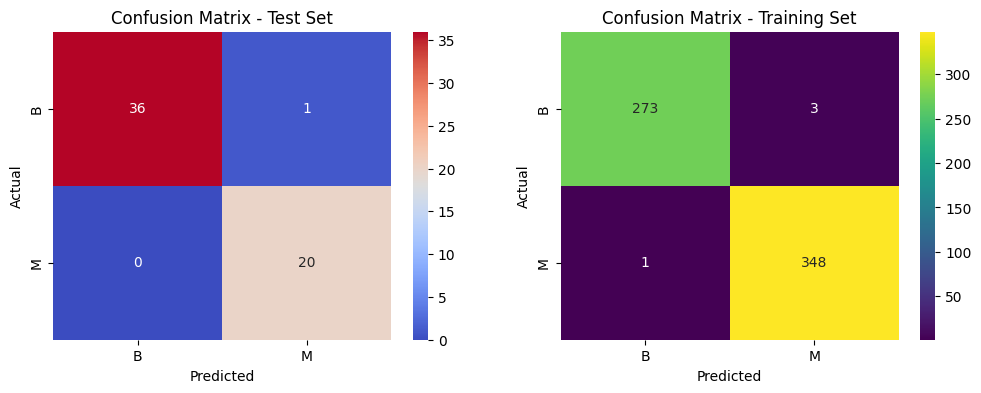

In [ ]:
# Generate the confusion matrix for the training set
train_confusion = pd.crosstab(train_df['target'], train_df['predicted'], rownames=['Actual'], colnames=['Predicted'])

# Extract True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN) for the training set
TP_train = train_confusion.iloc[1, 1]
TN_train = train_confusion.iloc[0, 0]
FP_train = train_confusion.iloc[0, 1]
FN_train = train_confusion.iloc[1, 0]

# Calculate Precision, Recall, and F1 Score for the training set
precision_train = TP_train / (TP_train + FP_train)
recall_train = TP_train / (TP_train + FN_train)
f1_score_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)

# Display training metrics
print('Training Set Precision:', precision_train)
print('Training Set Recall:', recall_train)
print('Training Set F1 Score:', f1_score_train)
print("-------------------------------------------------------------------------------")

# Generate the confusion matrix for the test set
test_confusion = pd.crosstab(test_df['target'], test_df['predicted'], rownames=['Actual'], colnames=['Predicted'])

# Extract TP, TN, FP, and FN values for the test set
TP_test = test_confusion.iloc[1, 1]
TN_test = test_confusion.iloc[0, 0]
FP_test = test_confusion.iloc[0, 1]
FN_test = test_confusion.iloc[1, 0]

# Calculate Precision, Recall, and F1 Score for the test set
precision_test = TP_test / (TP_test + FP_test)
recall_test = TP_test / (TP_test + FN_test)
f1_score_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)

# Display test metrics
print('Test Set Precision:', precision_test)
print('Test Set Recall:', recall_test)
print('Test Set F1 Score:', f1_score_test)
print("-------------------------------------------------------------------------------")

# Plot confusion matrices for training and test sets side-by-side
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='coolwarm')
plt.title('Confusion Matrix - Test Set')

plt.subplot(1, 2, 2)
sns.heatmap(train_confusion, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix - Training Set')

plt.show()





## **Performance Evaluation using Sklearn**

In this code, we implement a stratified k-fold cross-validation procedure to evaluate the performance of a decision tree classifier on a dataset. We start by setting up `StratifiedKFold` with 10 splits, ensuring that each fold maintains the proportion of target classes. We separate the features and target variable from the dataset and initialize lists to store F1 scores for both training and test sets. We then iterate through each fold, splitting the dataset into training and test subsets. For each fold, we build the decision tree using the training data and make predictions for both the training and test sets.

During each iteration, we calculate the F1 score for both the training and test datasets based on the predicted values. We keep track of the best fold by monitoring the highest test F1 score, storing the relevant training and test datasets. After completing all folds, we output the best fold and its corresponding F1 score. Additionally, we calculate and print the mean and standard deviation of the F1 scores across all folds for both training and testing data, providing an overall performance measure for the decision tree model.

Finally, we generate confusion matrices for the best fold’s training and test sets and visualize them using heatmaps. These matrices display counts of true positives, true negatives, false positives, and false negatives, enabling us to assess the model's classification performance visually. We conclude with a plot of the F1 scores across the folds, including error bars that reflect the standard deviation, allowing for a clear comparison of the model's performance on the training and test datasets.

### **References**
[ScikitLearn Blog](https://www.simplilearn.com/tutorials/python-tutorial/scikit-learn) - To better understand the different features of Scikit Learn.

---------------------------------------------------------------------------------------------------------------------
Best fold: 5
Best fold F1 Score (Test): 0.9767441860465117
---------------------------------------------------------------------------------------------------------------------
F1 Score for Training : 0.9842464451886274 +- 0.004077404301314065
F1 Score for Testing : 0.9194397413461808+-0.037765715739993926
---------------------------------------------------------------------------------------------------------------------


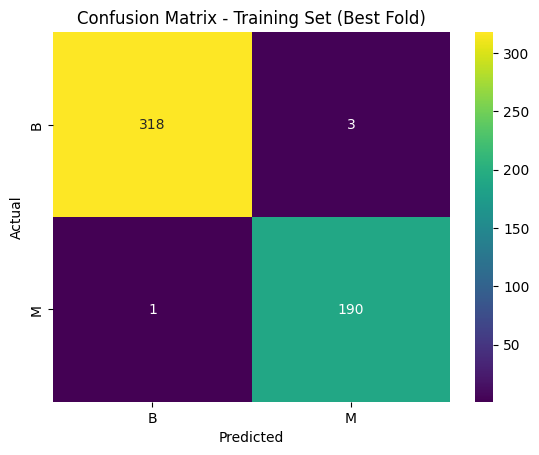

---------------------------------------------------------------------------------------------------------------------


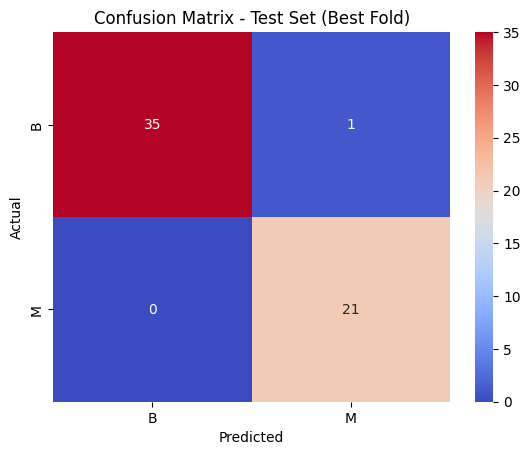

---------------------------------------------------------------------------------------------------------------------


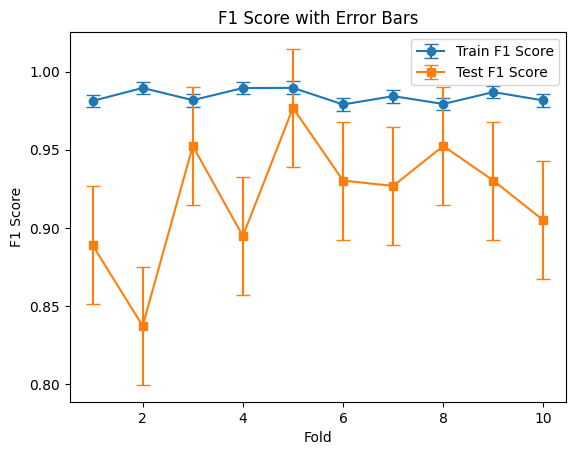

In [ ]:
# StratifiedKFold setup
num_folds = 10
skf = StratifiedKFold(n_splits=num_folds)

X = df.drop('target', axis=1)  # Features
y = df['target']  # Target variable

f1_scores_train = []
f1_scores_test = []
best_fold = None
best_f1_test = -1
best_train_data, best_test_data = None, None

fold_id = 1
for train_index, test_index in skf.split(X, y):
    # Split into training and test data for the current fold
    train_data = df.iloc[train_index].copy()
    test_data = df.iloc[test_index].copy()

    # Build decision tree (assuming build_tree and classify are defined)
    decision_tree = build_tree(train_data)

    # Predict for the training set
    train_data['predicted'] = train_data.apply(lambda x: classify(decision_tree, x), axis=1)

    # Predict for the test set
    test_data['predicted'] = test_data.apply(lambda x: classify(decision_tree, x), axis=1)

    # Calculate F1 score for the training data
    f1_train = f1_score(train_data['target'], train_data['predicted'], pos_label='M')
    f1_scores_train.append(f1_train)

    # Calculate F1 score for the test data
    f1_test = f1_score(test_data['target'], test_data['predicted'], pos_label='M')
    f1_scores_test.append(f1_test)

    # Keep track of the best fold based on test F1 score
    if f1_test > best_f1_test:
        best_f1_test = f1_test
        best_fold = fold_id
        best_train_data = train_data
        best_test_data = test_data

    fold_id += 1
print("---------------------------------------------------------------------------------------------------------------------")
# Output the best fold and its F1 score
print("Best fold:", best_fold)
print("Best fold F1 Score (Test):", best_f1_test)
print("---------------------------------------------------------------------------------------------------------------------")
# Calculate mean and standard deviation of F1 scores
mean_f1_train = np.mean(f1_scores_train)
std_f1_train = np.std(f1_scores_train)
mean_f1_test = np.mean(f1_scores_test)
std_f1_test = np.std(f1_scores_test)

print("F1 Score for Training : " + str(mean_f1_train) + " +- " + str(std_f1_train))
print("F1 Score for Testing : " + str(mean_f1_test) + "+-" + str(std_f1_test))
print("---------------------------------------------------------------------------------------------------------------------")
# Generate confusion matrix for the best fold's test set
test_confusion = confusion_matrix(best_test_data['target'], best_test_data['predicted'])

# Generate confusion matrix for the best fold's training set
train_confusion = confusion_matrix(best_train_data['target'], best_train_data['predicted'])

# Plot Confusion Matrix for Training Set
sns.heatmap(train_confusion, annot=True, fmt='d', cmap='viridis', xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.title('Confusion Matrix - Training Set (Best Fold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("---------------------------------------------------------------------------------------------------------------------")


# Plot Confusion Matrix for Test Set
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='coolwarm', xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.title('Confusion Matrix - Test Set (Best Fold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("---------------------------------------------------------------------------------------------------------------------")

# Plot F1 score with error bars
plt.errorbar(range(1, num_folds + 1), f1_scores_train, yerr=std_f1_train, label='Train F1 Score', fmt='o-', capsize=5)
plt.errorbar(range(1, num_folds + 1), f1_scores_test, yerr=std_f1_test, label='Test F1 Score', fmt='s-', capsize=5)
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('F1 Score with Error Bars')
plt.legend()
plt.show()


## **Conclusion**

In the 10-fold cross-validation, we saw an impressive F1 score of around **0.984** for the training set, showing that our model fits the training data very well, with only a small variability of **0.004**. The test set F1 score of about **0.919** indicates that the model performs well on unseen data, although this score is naturally lower than the training score due to the risk of overfitting. On the other hand, the regular split with random shuffling gave us even better results, with a training F1 score of **0.992** and a test score of **0.950**, highlighting strong generalization. Notably, the close F1 scores of **0.984** (from cross-validation) and **0.950** (from the regular split) reinforce the reliability of our findings, suggesting that the decision tree classifier is consistently effective, no matter which evaluation method we use.

When observing the error bars, we notice significant variation in the test F1 scores compared to the training F1 scores, with the test scores ranging from a high of **0.97** to a low of **0.83**. This is due to the limited amount of data available to test as compared to the training data. Despite this variability, the overall average F1 score remains high, as highlighted in the previous paragraph. This suggests that the method is effective in identifying the best test-train split to achieve optimal results. In contrast, the training F1 scores remain relatively stable with only minor fluctuations, indicating that the decision tree effectively manages large datasets without overfitting.


---



### ***ChatGPT - To check my grammar and ensure that all our comments are accurate.It was also used to fine tune the graphs ( Include B and M labels instead of 0 and 1). To find out if I need to use iloc or loc to create copies of the dataframe. Also asked for some ideal values for max depth and min split to have a range of values to work with.***

# **Question 1 Part 2**
### **Naive Bayes classifier which uses Gaussian modeling for continuous features**

The Naive Bayes classifier is a probabilistic model based on Bayes' theorem and is widely used for classification tasks, especially with text and categorical data. A key feature of Naive Bayes is its *naivety*, as it assumes that the features are independent of each other given the class label. Despite this assumption often being unrealistic, Naive Bayes can perform surprisingly well, even on complex tasks.

For continuous features, we commonly use the *Gaussian Naive Bayes* variant, which models each feature with a Gaussian (normal) distribution. Here, the probability density function for each feature is calculated based on the mean and standard deviation, estimated from the training data. This approach allows Gaussian Naive Bayes to capture the distribution of continuous variables effectively, making it suitable for datasets where features follow a normal distribution or can be approximated as such.

**References**

- [Naive Bayes](https://medium.com/@shuv.sdr/na%C3%AFve-bayes-classification-in-python-f869c2e0dbf1) - Learnt what are the steps involved in Naive Bayes.





### **Splitting the Dataset**

The `train_test_split` function is a custom implementation to split a dataset into training and test subsets. It first sets a random seed (`np.random.seed(40)`) for consistent, reproducible results. The function then shuffles the indices of the dataset, ensuring randomness in the split. It calculates a split index based on the specified `test_size` proportion, which by default assigns 90% of the data to training and 10% to testing. Using these indices, the function divides the dataset into `X_train` and `X_test` for the features and `y_train` and `y_test` for the target labels. In this case, `X` represents all features except the target, and `y` holds the target values, both sourced from the input DataFrame `df`. This process allows us to prepare training and test sets efficiently without relying on external libraries.

In [20]:
# Custom function to split the dataset into train and test sets
def train_test_split(X, y, test_size=0.1):
    np.random.seed(40)  # For reproducibility
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_index = int(X.shape[0] * (1 - test_size))

    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

# Split the dataset into train and test sets
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y)

### **Implementation of the Gaussian Naive Bayes Classifier**

The following steps were performed in the code snippets below:

1. **Data Preparation:**
   - We began by loading the breast cancer dataset and splitting it into training and testing sets, shuffling the data to ensure a good mix of classes for model evaluation.

2. **Implementing the Gaussian Naive Bayes Classifier:**
   - We created a `GaussianNaiveBayes` class to encapsulate model training and prediction functionality, making the implementation more organized and reusable.
   - **Model Training (`fit` method):** For each class in the dataset, we calculated the mean, variance, and prior probability for each feature, storing these values to represent the Gaussian distributions for each class.
   - **Prediction (`predict` method):** During prediction, we computed the log-likelihood for each data point across all classes using the Gaussian distribution formula. We then selected the class with the highest posterior probability as the predicted label.

3. **Evaluating Model Performance:**
   - Using the trained model, we obtained predictions on both the training and test sets.
   - **Metrics Calculation:** We calculated precision, recall, and F1 scores to assess the classifier's accuracy and balance between classes on both the training and test sets.
   
4. **Confusion Matrix Visualization:**
   - For each set, we plotted confusion matrices using `seaborn` to visually analyze the classifier’s performance by showing correct and incorrect predictions for both classes.

   **References**
   - [Naive Bayes Implementation](https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/) - To read how Naive Bayes was implemented from scratch for the Iris Dataset.

In [19]:


# Implementing the Gaussian Naive Bayes classifier
class GaussianNaiveBayes:
    def fit(self, X, y):
        # Initialize class attributes for storing means, variances, and prior probabilities
        self.classes = np.unique(y)
        self.mean = {}
        self.variance = {}
        self.prior = {}

        # Calculate the mean, variance, and prior probability for each class
        for c in self.classes:
            X_c = X[y == c]  # Select data points for the current class
            self.mean[c] = X_c.mean(axis=0)  # Calculate feature means
            self.variance[c] = X_c.var(axis=0)  # Calculate feature variances
            self.prior[c] = X_c.shape[0] / X.shape[0]  # Calculate prior probabilities

    def predict(self, X):
        # Predict the class labels for the input data
        posterior = []  # List to store posterior probabilities for each class

        # Calculate the posterior probabilities based on prior and likelihood for each class
        for c in self.classes:
            prior = np.log(self.prior[c])  # Log of prior probability
            likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.variance[c])) - \
                         0.5 * np.sum(((X - self.mean[c]) ** 2) / self.variance[c], axis=1)  # Gaussian likelihood

            posterior.append(prior + likelihood)  # Combine prior and likelihood

        # Return the class with the highest posterior probability for each sample
        return self.classes[np.argmax(posterior, axis=0)]


### **Training and Testing**

Here, we are training and testing a Gaussian Naive Bayes model:

1. **Training the Model:** We create an instance of the Gaussian Naive Bayes model, `gnb`, and train it on the training data (`X_train` for features and `y_train` for labels) using the `fit()` method.

2. **Making Predictions:** Once the model is trained, we use it to predict labels for both the training set (`y_train_pred`) and the testing set (`y_test_pred`) by passing `X_train` and `X_test` data to the `predict()` method.

This code prepares the model for evaluating its performance on both seen (training) and unseen (testing) data.

In [21]:
# Train the model
gnb = GaussianNaiveBayes()
gnb.fit(X_train.values, y_train.values)

# Make predictions
y_train_pred = gnb.predict(X_train.values)
y_test_pred = gnb.predict(X_test.values)



### **Confusion Matrix and Performance Metrics Calculation**

This part of the code evaluates the performance of a classification model by calculating and displaying key metrics (precision, recall, and F1 score) and visualizing confusion matrices for both the training and testing sets.

1. **Metric Calculation**:
   - The `calculate_metrics` function computes **True Positives (TP)**, **True Negatives (TN)**, **False Positives (FP)**, and **False Negatives (FN)** based on the actual and predicted labels.
   - It calculates **precision** (TP / (TP + FP)), **recall** (TP / (TP + FN)), and **F1 score** (harmonic mean of precision and recall), with checks to avoid division by zero.
   - Labels are mapped to integers ('B' to 0, 'M' to 1) for easier calculation.
   - Metrics are calculated for both the training and testing sets and then printed.

2. **Confusion Matrix Visualization**:
   - The `plot_confusion_matrices` function creates and displays confusion matrices for the training and testing sets.
   - For each set, a 2x2 matrix is filled based on the true and predicted labels, counting instances of each class prediction.
   - These matrices are displayed as heatmaps using Seaborn, with distinct color schemes to differentiate training and testing data.
   - The confusion matrices show where the model correctly or incorrectly predicted each class.

Train precision: 0.9388888888888889
Train recall: 0.9037433155080213
Train F1 Score: 0.9209809264305178
--------------------------------------------------------------
Test precision: 0.9545454545454546
Test recall: 0.84
Test F1 Score: 0.8936170212765958
--------------------------------------------------------------


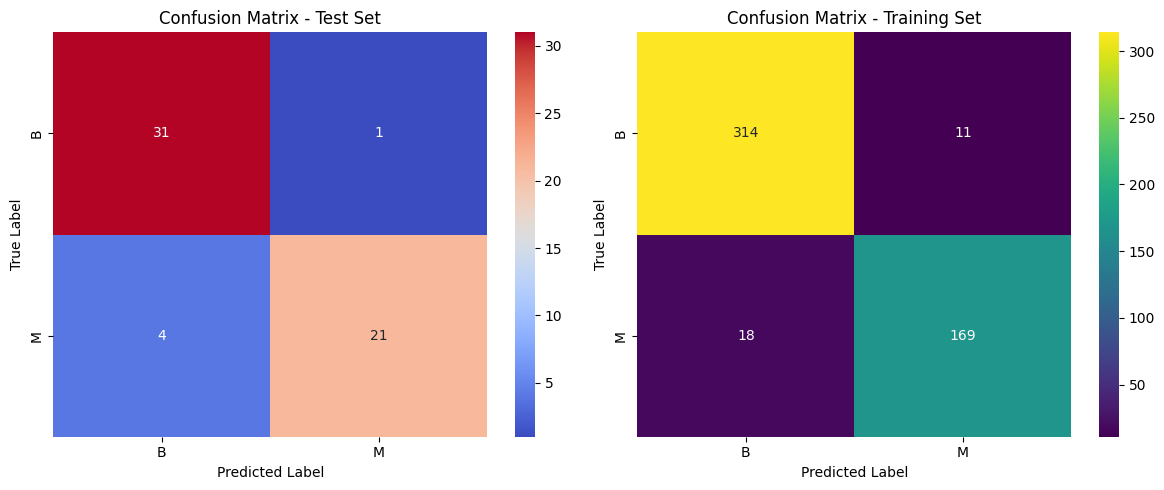

In [ ]:
# Function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    # Calculate True Positives, True Negatives, False Positives, and False Negatives
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # Calculate precision, recall, and F1 score with checks to avoid division by zero
    precision_nb = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_nb = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_nb = 2 * (precision_nb * recall_nb) / (precision_nb + recall_nb) if (precision_nb + recall_nb) > 0 else 0

    # Return the calculated metrics
    return precision_nb, recall_nb, f1_nb

# Map labels to integers for consistency in calculations
# Here, 'B' is mapped to 0 and 'M' is mapped to 1 for both true and predicted labels
y_train_mapped = np.where(y_train.values == 'B', 0, 1)
y_train_pred_mapped = np.where(y_train_pred == 'B', 0, 1)
y_test_mapped = np.where(y_test.values == 'B', 0, 1)
y_test_pred_mapped = np.where(y_test_pred == 'B', 0, 1)

# Calculate training and testing metrics using the defined function
train_precision_nb, train_recall_nb, train_f1 = calculate_metrics(y_train_mapped, y_train_pred_mapped)
test_precision_nb, test_recall_nb, test_f1 = calculate_metrics(y_test_mapped, y_test_pred_mapped)

# Print out the calculated metrics for training and testing sets
print("Train precision:", train_precision_nb)
print("Train recall:", train_recall_nb)
print("Train F1 Score:", train_f1)
print("--------------------------------------------------------------")
print("Test precision:", test_precision_nb)
print("Test recall:", test_recall_nb)
print("Test F1 Score:", test_f1)
print("--------------------------------------------------------------")

# Function to plot confusion matrices for both training and testing sets
def plot_confusion_matrices(y_train_true, y_train_pred, y_test_true, y_test_pred):
    # Initialize confusion matrix for training data
    train_confusion = np.zeros((2, 2))
    for i in range(len(y_train_true)):
        # Populate the matrix based on true and predicted labels
        train_confusion[int(y_train_true[i])][int(y_train_pred[i])] += 1

    # Initialize confusion matrix for testing data
    test_confusion = np.zeros((2, 2))
    for i in range(len(y_test_true)):
        # Populate the matrix based on true and predicted labels
        test_confusion[int(y_test_true[i])][int(y_test_pred[i])] += 1

    # Set up the figure and plot the test confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(test_confusion, annot=True, fmt='.0f', cmap='coolwarm', xticklabels=['B', 'M'], yticklabels=['B', 'M'])
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Plot the training confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(train_confusion, annot=True, fmt='.0f', cmap='viridis', xticklabels=['B', 'M'], yticklabels=['B', 'M'])
    plt.title('Confusion Matrix - Training Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot confusion matrices for training and testing data
plot_confusion_matrices(y_train_mapped, y_train_pred_mapped, y_test_mapped, y_test_pred_mapped)


### **Performance Evaluation using Sklearn**

Similar to what we did for the decision tree, we implement a stratified 10-fold cross-validation procedure to evaluate a decision tree classifier's performance. Using `StratifiedKFold` to maintain class proportions, we split the data into training and test sets for each fold, tracking F1 scores for both sets. For each fold, we train the decision tree and make predictions, calculating F1 scores and identifying the best-performing fold by its highest test F1 score. After all folds, we report the best fold, along with the mean and standard deviation of F1 scores across folds for both training and test sets, providing an overall performance measure. Finally, we visualize confusion matrices for the best fold using heatmaps and plot F1 scores across folds with error bars, enabling clear comparison of model performance.

### **References**
[ScikitLearn Blog](https://www.simplilearn.com/tutorials/python-tutorial/scikit-learn) - To better understand the different features of Scikit Learn.

Best Fold Number: 3
Best Fold F1 Score (Test): 0.9696969696969697 +- 0.014765831680856266
---------------------------------------------------------------------------------------------------------------------
F1 Score for Training : 0.9565231447222342 +- 0.002910440547757718
F1 Score for Testing : 0.9525590263845689 +- 0.014765831680856266
---------------------------------------------------------------------------------------------------------------------


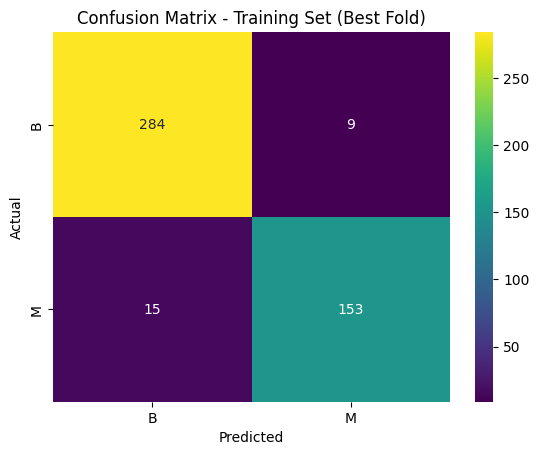

---------------------------------------------------------------------------------------------------------------------


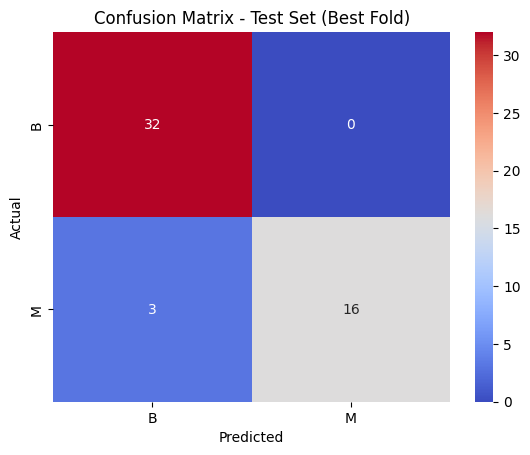

---------------------------------------------------------------------------------------------------------------------


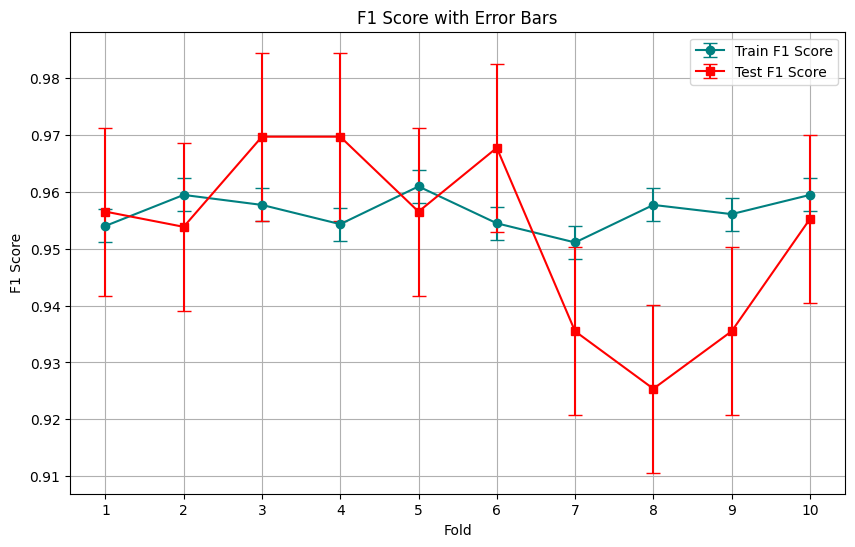

In [ ]:
# Initialize lists to store F1 scores
f1_scores_train = []
f1_scores_test = []

# Set up stratified 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)

# Perform cross-validation
for fold_index, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_cv_train, X_cv_test = X_train.values[train_index], X_train.values[test_index]
    y_cv_train, y_cv_test = y_train.values[train_index], y_train.values[test_index]

    gnb.fit(X_cv_train, y_cv_train)  # Fit the model
    y_cv_train_pred = gnb.predict(X_cv_train)  # Make predictions on train
    y_cv_test_pred = gnb.predict(X_cv_test)  # Make predictions on test

    # Calculate F1 scores for train and test
    f1_train = f1_score(y_cv_train, y_cv_train_pred, pos_label='B')
    f1_test = f1_score(y_cv_test, y_cv_test_pred, pos_label='B')

    f1_scores_train.append(f1_train)
    f1_scores_test.append(f1_test)

# Calculate the mean and standard deviation for train and test F1 scores
mean_f1_train = np.mean(f1_scores_train)
std_f1_train = np.std(f1_scores_train)

mean_f1_test = np.mean(f1_scores_test)
std_f1_test = np.std(f1_scores_test)

# Identify the best fold based on test F1 score
best_fold_index = np.argmax(f1_scores_test)  # Get the index of the best fold
best_f1_score = f1_scores_test[best_fold_index]
best_fold_number = best_fold_index + 1  # Add 1 to convert from index to fold number

# Print the best fold information
print("Best Fold Number:", best_fold_number)
print("Best Fold F1 Score (Test):", best_f1_score, "+-", std_f1_test)
print("---------------------------------------------------------------------------------------------------------------------")
print("F1 Score for Training : " + str(mean_f1_train) + " +- " + str(std_f1_train))
print("F1 Score for Testing : " + str(mean_f1_test) + " +- " + str(std_f1_test))
print("---------------------------------------------------------------------------------------------------------------------")

# Plot Confusion Matrix for Training Set
train_confusion = confusion_matrix(y_cv_train, y_cv_train_pred)  # Calculate confusion matrix for training set
sns.heatmap(train_confusion, annot=True, fmt='d', cmap='viridis', xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.title('Confusion Matrix - Training Set (Best Fold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("---------------------------------------------------------------------------------------------------------------------")

# Plot Confusion Matrix for Test Set
test_confusion = confusion_matrix(y_cv_test, y_cv_test_pred)  # Calculate confusion matrix for test set
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='coolwarm', xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.title('Confusion Matrix - Test Set (Best Fold)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("---------------------------------------------------------------------------------------------------------------------")

# Plot F1 score with error bars
plt.figure(figsize=(10, 6))
num_folds = 10
plt.errorbar(range(1, num_folds + 1), f1_scores_train, yerr=std_f1_train, label='Train F1 Score', fmt='o-', capsize=5, color='teal')
plt.errorbar(range(1, num_folds + 1), f1_scores_test, yerr=std_f1_test, label='Test F1 Score', fmt='s-', capsize=5, color='red')

plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('F1 Score with Error Bars')
plt.xticks(range(1, num_folds + 1))  # Set x-ticks to be the fold numbers
plt.legend()
plt.grid()
plt.show()


### **Conclusion**

The evaluation of the Naive Bayes classifier through stratified 10-fold cross-validation yielded impressive results. The best fold achieved a test F1 score of approximately 0.9697 with a training F1 score of 0.9565, indicating strong predictive capabilities and minimal variability in the model’s performance. Notably, the error bars for the best fold indicate that the F1 score can range from a low of approximately 0.9545 to a high of 0.9697, suggesting that the model maintains robust performance across different folds.


Furthermore, the scratch-built model demonstrates good precision on the test set at **0.9545**, but its recall is notably lower at **0.84**. This results in an overall F1 score that is significantly behind that of the cross-validated model. The disparity in performance metrics suggests that the model developed through stratified cross-validation not only generalizes well to unseen data but also maintains a better balance between precision and recall. Overall, the findings indicate that the stratified 10-fold cross-validation approach yields a more robust and reliable model compared to the one constructed from scratch.

### **Comparison Graph Between a Decision Tree classifier using Information Gain splitting criterion and a Gaussian Naive Bayes Classifier**

In this part of the code, we’re visualizing and comparing the training and testing performance metrics (Precision, F1 Score, and Recall) of the two classifiers.

- Storing Metrics: We store training and testing metrics in separate lists, train_metrics and test_metrics, where each list contains the Precision, F1 Score, and Recall values for each classifier.

- Setting Up Plot Data: We define the metric names, classifier names, bar width, and x-coordinates to properly position the bars on the plot.

- Creating Subplots: We set up two subplots, one for training metrics and another for testing metrics.

- Plotting Training Metrics: In the first subplot, we create a grouped bar chart for the training metrics of each classifier. Each metric (Precision, F1 Score, Recall) is represented by a different color, and they are offset along the x-axis to avoid overlap.

- Plotting Testing Metrics: In the second subplot, we repeat the same process for the testing metrics.

- Adding Labels, Titles, and Legends: We add axis labels, titles, and a legend to each subplot to clearly convey the meaning of each chart.

- Displaying Plots: Finally, we use plt.tight_layout() to adjust spacing and plt.show() to display the plots.

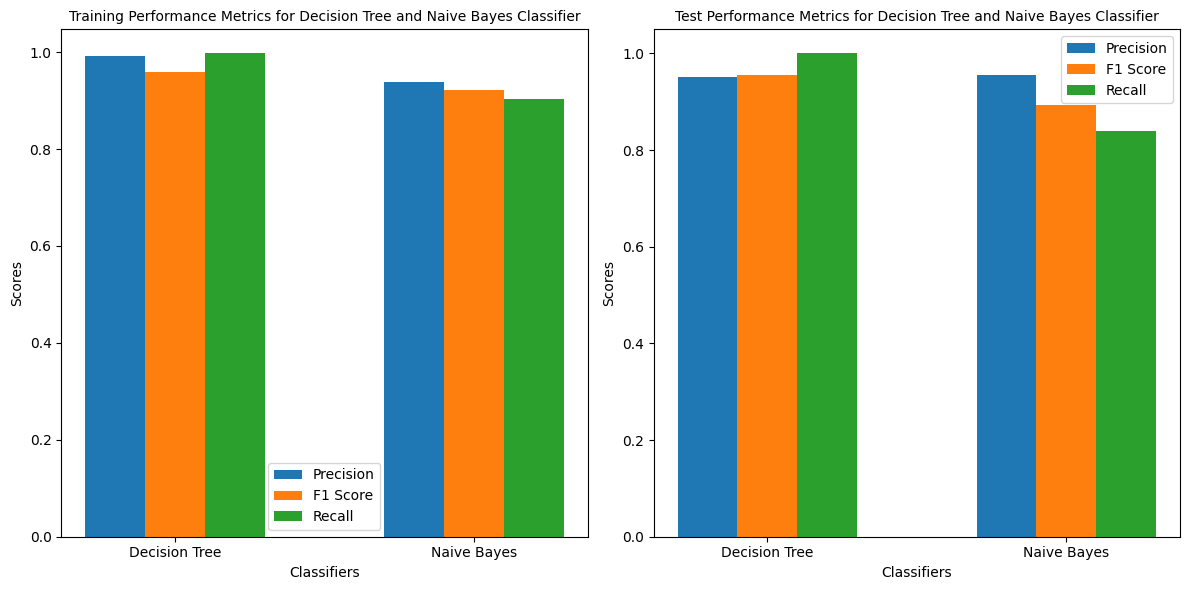

In [ ]:
# Store training metrics in a list
train_metrics = [
    [precision_train, f1_train, recall_train],  # Decision Tree
    [train_precision_nb, train_f1, train_recall_nb]    # Naive Bayes
]

# Store testing metrics in a list
test_metrics = [
    [precision_test, f1_test, recall_test],      # Decision Tree
    [test_precision_nb, test_f1, test_recall_nb]       # Naive Bayes
]


# Prepare data for plotting
metric_names = ['Precision', 'F1 Score', 'Recall']
classifier_names = ['Decision Tree', 'Naive Bayes']


bar_width = 0.2  # Width of each bar
x = np.arange(len(classifier_names))

# Create the training bar graph
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # Create a subplot for both graphs

# Plot training metrics
for i in range(len(metric_names)):
    ax[0].bar(x + i * bar_width, [train_metrics[j][i] for j in range(len(classifier_names))], width=bar_width, label=metric_names[i])

# Add labels and title for training metrics
ax[0].set_xlabel('Classifiers')
ax[0].set_ylabel('Scores')
ax[0].set_title('Training Performance Metrics for Decision Tree and Naive Bayes Classifier', size = 10)
ax[0].set_xticks(x + bar_width)
ax[0].set_xticklabels(classifier_names)
ax[0].legend()

# Plot testing metrics
for i in range(len(metric_names)):
    ax[1].bar(x + i * bar_width, [test_metrics[j][i] for j in range(len(classifier_names))], width=bar_width, label=metric_names[i])

# Add labels and title for testing metrics
ax[1].set_xlabel('Classifiers')
ax[1].set_ylabel('Scores')
ax[1].set_title('Test Performance Metrics for Decision Tree and Naive Bayes Classifier', size = 10)
ax[1].set_xticks(x + bar_width)
ax[1].set_xticklabels(classifier_names)
ax[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

### **Conclusion for the above Graph**

The Decision Tree classifier outperforms the Naive Bayes classifier, achieving a higher recall of 0.955 compared to 0.8936 and an F1 score of 0.95 versus 0.84. This indicates that the Decision Tree is more effective at identifying positive instances while maintaining strong precision, suggesting a better overall balance between precision and recall. Therefore, the Decision Tree is the preferable model for this classification task.

---



### ***ChatGPT - To check my grammar and ensure that all our comments are accurate.It was also used to fine tune the graphs ( Include B and M labels instead of 0 and 1). Asked what exactly is the gaussian likelihood and tested to see if my likelihood formula was correct.***


# **Question 2 Part 1**

### Singular Value Decomposition is one of the efficient tools to reduce the dimensionality of a dataset by selecting top r features of the dataset.

### Below steps describes how we implemented dimensionality reduction using SVD.
- Data Preperation: Dataset was split into 2 sets training and testing sets.
- Implementing SVD: We implemented SVD using numpy.linalg. SVD is applied to training dataset to decompose it into U, S, Vt.
- Applying it on different ranks: For every rank (number of feature) from 2 to 30 we decompose our training dataset to get top rank features depicted in S.
- Dimensionality reduction: After we get top rank features, we reduce dimensionality of training set and we project these many features in test dataset.
- Getting F1 scores: We get F1 scores with the reduced datasets to compare the performance.
- Plotting: After getting F1 scores, we plot them to see how many features are optimal.

In [24]:
from numpy.linalg import svd

# Select only numeric columns from train_df for SVD
numeric_features = train_df.drop(columns='target').select_dtypes(include=[np.number])

# Perform SVD on train_df's numeric features
U, S, Vt = svd(numeric_features.values, full_matrices=False)
dt_scores = []
nb_scores = []
ranks = np.arange(2, 31)

# Store y_train and y_test separately for repeated use
y_train = train_df['target'].values
y_test = test_df['target'].values

# Precomputed SVD matrices for efficient dimensionality reduction
U_train = U[:, :max(ranks)]
S_train = np.diag(S[:max(ranks)])
Vt_test = Vt[:max(ranks), :]

for rank in ranks:
    # Reduce dimensionality using precomputed SVD matrices
    X_train_reduced = np.dot(U_train[:, :rank], S_train[:rank, :rank])
    X_test_reduced = np.dot(test_df[numeric_features.columns].values, Vt_test[:rank, :].T)

    # Convert reduced datasets to DataFrames and add the target variable
    train_reduced_df = pd.DataFrame(X_train_reduced)
    train_reduced_df['target'] = y_train

    test_reduced_df = pd.DataFrame(X_test_reduced)
    test_reduced_df['target'] = y_test

    # Build the decision tree with optimized depth and split settings
    decision_tree = build_tree(train_reduced_df)

    # Predict using the classify function
    y_pred_dt = test_reduced_df.apply(lambda row: classify(decision_tree, row), axis=1)

    # Calculate F1 score for the decision tree predictions
    dt_f1 = f1_score(y_test, y_pred_dt, pos_label='B')
    dt_scores.append(dt_f1)

  # Train and evaluate Naive Bayes
    nb = GaussianNaiveBayes()
    nb.fit(X_train_reduced, y_train)
    y_pred_nb = nb.predict(X_test_reduced)
    nb_f1 = f1_score(y_test, y_pred_nb, pos_label='B')
    nb_scores.append(nb_f1)




### **Graphical Analysis before Stratified K Fold Validation**

We have plotted performance of Naive Bayes and Decision Tree classifier for different number of features to see how number of features affect the performance without using Stratified K fold Validation.


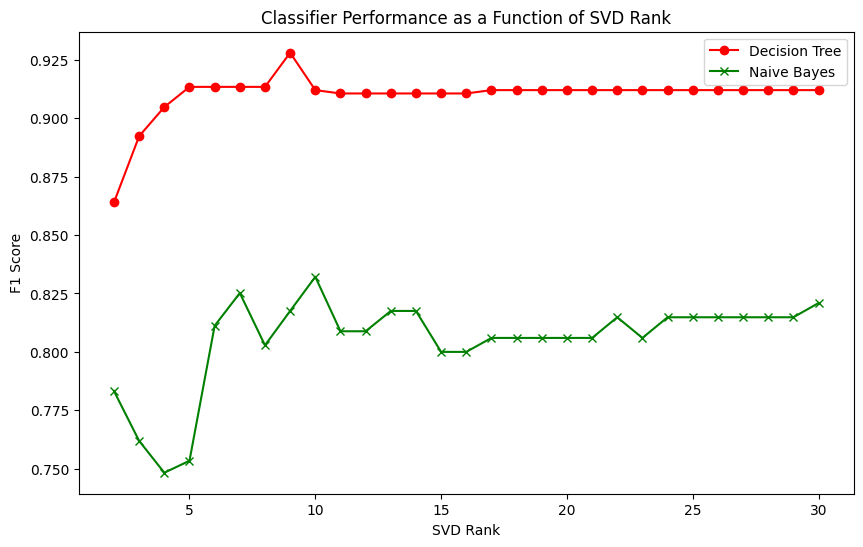

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(ranks, dt_scores, label='Decision Tree', marker='o', color = "red")
plt.plot(ranks, nb_scores, label='Naive Bayes', marker='x', color = "green")
plt.xlabel('SVD Rank')
plt.ylabel('F1 Score')
plt.title('Classifier Performance as a Function of SVD Rank')
plt.legend()
plt.show()

### **Conclusion**

- This plot shows the mean and std deviation F1 scores of two classifiers, Decision Tree (in red) and Naive Bayes (in green), as a function of SVD rank (r), where SVD rank represents the number of components used after applying Singular Value Decomposition (SVD) for dimensionality reduction.
- The Decision Tree classifier maintains a consistently high F1 score around 0.94 across most SVD ranks.
- Any rank between 6 and 10 seems sufficient to achieve optimal performance with the Decision Tree.
- The Naive Bayes classifier shows more fluctuation in F1 score as the SVD rank changes, with scores ranging between 0.88 and 0.92.
- The optimal performance for Naive Bayes is achieved at around rank 3 or 4 where the F1 score peaks, suggesting that a smaller number of features may work better for this model.
- Unlike the Decision Tree, Naive Bayes shows sensitivity to the number of components, and performance does not steadily improve with increased dimensionality.
- The plot indicates that Decision Tree performs well with a moderate number of components (6–10), while Naive Bayes performs best with a smaller number (3–4).

### **Performance Analysis after using Stratified K fold Validation**

This code performs dimensionality reduction and model evaluation using stratified k-fold cross-validation. It begins by computing the Singular Value Decomposition (SVD) of the numeric features in `train_df` (excluding the target column) to create matrices that can later reduce the dataset’s dimensionality. For each dimensionality rank, from 2 to 30, the numeric data is projected into a lower-dimensional space, which helps simplify the dataset and potentially improve model performance by removing noise. To ensure the target class distribution remains consistent across training and testing splits, it applies a 10-fold stratified cross-validation, iterating through each split with the chosen dimensionality reduction rank.

Within each fold, it trains and evaluates two models: a decision tree and a Naive Bayes classifier. The decision tree model uses a custom `build_tree` function, and predictions are made with a `classify` function. The Naive Bayes classifier, created with `GaussianNaiveBayes`, is also trained and evaluated on the reduced dataset. F1 scores are computed for each model to measure the balance of precision and recall, specifically for class "Benign." After each fold, the F1 scores are averaged across all folds for each rank, providing an overall performance metric for each model at various ranks. These average scores, stored in `dt_avg_scores` and `nb_avg_scores`, allow comparison of model effectiveness across different dimensionalities.

In [ ]:
from numpy.linalg import svd


# Select only numeric columns from train_df for SVD
numeric_features = train_df.drop(columns='target').select_dtypes(include=[np.number])

# Precomputed SVD matrices for efficient dimensionality reduction
U, S, Vt = svd(numeric_features.values, full_matrices=False)
ranks = np.arange(2, 31)

# Store y values for repeated use
y = train_df['target'].values

# Initialize lists to store average F1 scores across folds
dt_avg_scores = []
nb_avg_scores = []
nb_std_devs = []
dt_std_devs = []

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=10)
for rank in ranks:
    dt_fold_scores = []
    nb_fold_scores = []
    
    for train_index, test_index in skf.split(numeric_features, y):
        X_train, X_test = numeric_features.values[train_index], numeric_features.values[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Reduce dimensionality using precomputed SVD matrices
        U_train = U[train_index, :rank]
        S_train = np.diag(S[:rank])
        Vt_test = Vt[:rank, :]

        X_train_reduced = np.dot(U_train, S_train)
        X_test_reduced = np.dot(X_test, Vt_test.T)

        # Convert reduced datasets to DataFrames and add the target variable
        train_reduced_df = pd.DataFrame(X_train_reduced)
        train_reduced_df['target'] = y_train

        test_reduced_df = pd.DataFrame(X_test_reduced)
        test_reduced_df['target'] = y_test

        # Build and evaluate the decision tree model
        decision_tree = build_tree(train_reduced_df)
        y_pred_dt = test_reduced_df.apply(lambda row: classify(decision_tree, row), axis=1)
        dt_f1 = f1_score(y_test, y_pred_dt, pos_label='B')
        dt_fold_scores.append(dt_f1)

        # Build and evaluate the Naive Bayes model
        nb = GaussianNaiveBayes()
        nb.fit(X_train_reduced, y_train)
        y_pred_nb = nb.predict(X_test_reduced)
        nb_f1 = f1_score(y_test, y_pred_nb, pos_label='B')
        nb_fold_scores.append(nb_f1)
    
    # Calculate the average F1 score for each rank across all folds
    dt_avg_scores.append(np.mean(dt_fold_scores))
    nb_avg_scores.append(np.mean(nb_fold_scores))
    nb_std_devs.append(np.mean(np.std(nb_fold_scores)))
    dt_std_devs.append(np.std(dt_fold_scores))

# dt_avg_scores and nb_avg_scores now contain the average F1 scores for each rank across folds


### **Mean F1 Score and Standard Deviation Calculation**

In [ ]:

# After the loop where you calculate average scores and standard deviations
for rank, dt_mean, dt_std, nb_mean, nb_std in zip(ranks, dt_avg_scores, dt_std_devs, nb_avg_scores, nb_std_devs):
    print("Rank {}:".format(rank))
    print("  Decision Tree - Mean F1: {:.4f} ± {:.4f}".format(dt_mean, dt_std))
    print("  Naive Bayes - Mean F1: {:.4f} ± {:.4f}".format(nb_mean, nb_std))
    print()


Rank 2:
  Decision Tree - Mean F1: 0.9441 ± 0.0217
  Naive Bayes - Mean F1: 0.9436 ± 0.0299

Rank 3:
  Decision Tree - Mean F1: 0.9382 ± 0.0217
  Naive Bayes - Mean F1: 0.9360 ± 0.0299

Rank 4:
  Decision Tree - Mean F1: 0.9616 ± 0.0217
  Naive Bayes - Mean F1: 0.9300 ± 0.0299

Rank 5:
  Decision Tree - Mean F1: 0.9491 ± 0.0217
  Naive Bayes - Mean F1: 0.9314 ± 0.0299

Rank 6:
  Decision Tree - Mean F1: 0.9443 ± 0.0217
  Naive Bayes - Mean F1: 0.9397 ± 0.0299

Rank 7:
  Decision Tree - Mean F1: 0.9429 ± 0.0217
  Naive Bayes - Mean F1: 0.9422 ± 0.0299

Rank 8:
  Decision Tree - Mean F1: 0.9417 ± 0.0217
  Naive Bayes - Mean F1: 0.9405 ± 0.0299

Rank 9:
  Decision Tree - Mean F1: 0.9480 ± 0.0217
  Naive Bayes - Mean F1: 0.9432 ± 0.0299

Rank 10:
  Decision Tree - Mean F1: 0.9480 ± 0.0217
  Naive Bayes - Mean F1: 0.9430 ± 0.0299

Rank 11:
  Decision Tree - Mean F1: 0.9575 ± 0.0217
  Naive Bayes - Mean F1: 0.9408 ± 0.0299

Rank 12:
  Decision Tree - Mean F1: 0.9589 ± 0.0217
  Naive Bayes - 

### **Graphical Analysis after Stratified K Fold Validation**

We have plotted performance of Naive Bayes and Decision Tree classifier for different number of features to see how number of features affect the performance using Stratified K fold Validation.

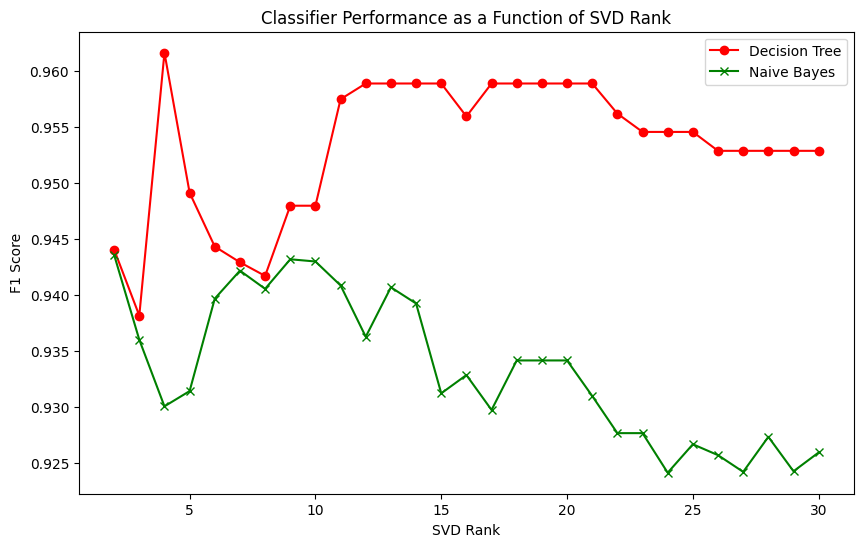

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(ranks, dt_avg_scores, label='Decision Tree', marker='o', color = "red")
plt.plot(ranks, nb_avg_scores, label='Naive Bayes', marker='x', color = "green")
plt.xlabel('SVD Rank')
plt.ylabel('F1 Score')
plt.title('Classifier Performance as a Function of SVD Rank')
plt.legend()
plt.show()

### **Conclusion**

- Decision Tree Performance: The Decision Tree classifier generally performs well across different SVD ranks, with high F1 scores. It reaches a peak at low ranks, then stabilizes around a high F1 score close to 0.96 for a range of ranks (around 10–20), before slightly declining as the rank increases. This suggests that the Decision Tree classifier is relatively robust to dimensionality reduction up to a point, achieving its best performance with a moderate SVD rank.

- Naive Bayes Performance: The Naive Bayes classifier shows a lower and more fluctuating F1 score as SVD rank increases, with values generally below 0.945. It appears less stable and less suited to the reduced feature space compared to the Decision Tree. As the SVD rank increases, its F1 score decreases gradually, suggesting that it may struggle more with higher-dimensional representations after dimensionality reduction.

# Question 3 Part 1

### Feature Randomization:
It is an useful feature to see if in a feature if we permutate random values, is there any change in scoring metrices.

To implement Feature Randomization we:
- Took 20% sample for feature randomization.
- For each feature we did 5 cross validation to calculate performance.
- For each fold we permutated feature values and tested with Decision Tree and Naive Bayes model.
- We took mean and standard deviation of performance drop for each clasiffier.
- We then plot the results

***References:***
- https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedKFold.html
- https://ramprasad.mse.gatech.edu/wp-content/uploads/2018/03/129.pdf

In [ ]:
# Splitting dataset into 80-20 split, where 20% of data will be used to rank features based on information score
X_eval, X_sample, y_eval, y_sample = train_test_split(X, y, test_size=0.2)

# We will use these dictionaries to keep track of feature wise information score
importance_score_nb = {}
importance_score_dt = {}

### **Extracting Feature Importance**

1. **Feature Randomization for Importance Calculation**:
   - For each feature in `X_sample`, the code uses 5-fold stratified cross-validation to evaluate how randomizing the feature affects model performance. It does this by shuffling the values of the feature in the training data, which simulates removing the information contributed by that feature.
   
2. **Model Evaluation**:
   - In each fold, it trains two models: a decision tree (using a custom `build_tree` function) and a Naive Bayes model. Each model is trained on both the original data and the data with the feature randomized. F1 scores are calculated on the test data for both the original and randomized versions.
   
   - The performance drop (or "importance score") is computed as the percentage difference in F1 scores between the original and randomized feature versions, indicating the feature’s significance to model accuracy. The average and standard deviation of the performance drops across folds are saved in `importance_score_nb` (Naive Bayes) and `importance_score_dt` (decision tree) for each feature.

In [ ]:
# Iterating over each feature to get mean and std f1 score for both the classifiers
for feature in X_sample.columns:

    # Converting to numpy array
    X_sample_np = X_sample.to_numpy()
    y_sample_np = y_sample.to_numpy()

    performance_drop_dt = []
    performance_drop_nb = []

    # Using 5-fold stratified cross-validator
    for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True).split(X_sample, y_sample):
        X_train_fold = X_sample_np[train_index]
        X_test_fold = X_sample_np[test_index]

        y_train_fold = y_sample_np[train_index]
        y_test_fold = y_sample_np[test_index]

        X_sample_randomized = X_sample.copy()

        # Randomize the feature in the training fold
        X_sample_randomized[feature] = np.random.permutation(X_sample_randomized[feature])
        X_sample_randomized_np = X_sample_randomized.to_numpy()

        X_train_randomized_fold = X_sample_randomized_np[train_index]
        X_test_randomized_fold = X_sample_randomized_np[test_index]

        # Decision Tree (Custom)
        # Prepare training data as a DataFrame (including target 'y_train_fold')
        train_data = pd.DataFrame(X_train_fold, columns=X_sample.columns)
        train_data['target'] = y_train_fold

        # Build the tree using your function
        tree = build_tree(train_data)

        # Make predictions on the original test fold using the classify function
        test_data = pd.DataFrame(X_test_fold, columns=X_sample.columns)

        # Ensure test_data and y_test_fold have the same length
        assert len(test_data) == len(y_test_fold), f"Length mismatch: {len(test_data)} != {len(y_test_fold)}"

        # Get predictions for the original test fold
        y_pred_dt_fold = [classify(tree, row) for _, row in test_data.iterrows()]  # Apply classify row by row

        # Ensure y_test_fold and y_pred_dt_fold have the same length
        assert len(y_test_fold) == len(y_pred_dt_fold), f"Length mismatch: {len(y_test_fold)} != {len(y_pred_dt_fold)}"

        # Calculate f1 score for decision tree
        f1_score_dt = f1_score(y_test_fold, y_pred_dt_fold, pos_label='B')

        # Make predictions on the randomized test fold using the classify function
        test_data_randomized = pd.DataFrame(X_test_randomized_fold, columns=X_sample.columns)

        # Get predictions for the randomized test fold
        y_pred_dt_randomized_fold = [classify(tree, row) for _, row in test_data_randomized.iterrows()]  # Apply classify row by row

        # Ensure y_test_fold and y_pred_dt_randomized_fold have the same length
        assert len(y_test_fold) == len(y_pred_dt_randomized_fold), f"Length mismatch: {len(y_test_fold)} != {len(y_pred_dt_randomized_fold)}"

        f1_score_dt_randomized = f1_score(y_test_fold, y_pred_dt_randomized_fold, pos_label='B')

        performance_drop_dt.append(((f1_score_dt - f1_score_dt_randomized) / f1_score_dt) * 100)

        # Naive Bayes
        nb = GaussianNaiveBayes()

        # Training with original values
        nb.fit(X_train_fold, y_train_fold)
        y_pred_nb_fold = nb.predict(X_test_fold)
        f1_score_nb = f1_score(y_test_fold, y_pred_nb_fold, pos_label='B')

        # Training on randomly permuted values
        nb.fit(X_train_randomized_fold, y_train_fold)
        y_pred_nb_randomized_fold = nb.predict(X_test_randomized_fold)
        f1_score_nb_randomized = f1_score(y_test_fold, y_pred_nb_randomized_fold, pos_label='B')

        # Importance score if ((F1_score_original - F1_score_randomly_permutated) / F1_score_original) * 100
        performance_drop_nb.append(((f1_score_nb - f1_score_nb_randomized) / f1_score_nb) * 100)

    importance_score_nb[feature] = {'mean': np.mean(performance_drop_nb), 'std': np.std(performance_drop_nb)}
    importance_score_dt[feature] = {'mean': np.mean(performance_drop_dt), 'std': np.std(performance_drop_dt)}


### **Randomizing Function for Naive Bayes**

In [ ]:
def get_stratified_naive_bayes_f1_score(num_folds, X, y):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=40)
    f1_scores_test = []
    for train_index, test_index in skf.split(X, y):
        # Split into training and test data for the current fold
        X_cv_train, X_cv_test = X.iloc[train_index], X.iloc[test_index]
        y_cv_train, y_cv_test = y.iloc[train_index], y.iloc[test_index]

        # Fitting on Naive Bayes classifier
        gnb = GaussianNaiveBayes()  # Ensure this matches your import or definition
        gnb.fit(X_cv_train, y_cv_train)
        y_cv_test_pred = gnb.predict(X_cv_test)

        # Calculate F1 score for the test data
        f1_test = f1_score(y_cv_test, y_cv_test_pred, pos_label='B')
        f1_scores_test.append(f1_test)

    return np.mean(f1_scores_test), np.std(f1_scores_test)

### **Randomizing Function for Decision Trees**

In [ ]:
def get_stratified_decision_tree_f1_score(num_folds, X, y):
  skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=40)
  f1_scores_test = []
  for train_index, test_index in skf.split(X, y):
    # Split into training and test data for the current fold
    train_data = df.iloc[train_index].copy()
    test_data = df.iloc[test_index].copy()

    # Build decision tree (assuming build_tree and classify are defined)
    decision_tree = build_tree(train_data)

    # Predict for the training set
    train_data['predicted'] = train_data.apply(lambda x: classify(decision_tree, x), axis=1)

    # Predict for the test set
    test_data['predicted'] = test_data.apply(lambda x: classify(decision_tree, x), axis=1)

    # Calculate F1 score for the test data
    f1_test = f1_score(test_data['target'], test_data['predicted'], pos_label='M')
    f1_scores_test.append(f1_test)
  return np.mean(f1_scores_test), np.std(f1_scores_test)

### **Feature Sorting and Performance Metrics Calculation**

In [ ]:
# Sort features by their mean importance score in descending order
sorted_features_nb = sorted(importance_score_nb, key=lambda x: importance_score_nb[x]['mean'], reverse=True)
top_ten_features_nb = sorted_features_nb[:10]

sorted_features_dt = sorted(importance_score_dt, key=lambda x: importance_score_dt[x]['mean'], reverse=True)
top_ten_features_dt = sorted_features_dt[:10]

**Mean and Standard Deviation of F1 score for Naive Bayes including all the features**

In [ ]:
mean_f1_cv_nb, std_f1_cv_nb  = get_stratified_naive_bayes_f1_score(10, X_eval, y_eval)
print("Mean F1 Score +- Standard Deviation:", mean_f1_cv_nb, "+-", std_f1_cv_nb)

Mean F1 Score +- Standard Deviation: 0.9518054807067079 +- 0.02104071498106035


***Mean and Standard Deviation of F1 score for Naive Bayes including top 10 features***

In [ ]:
# Corrected call to the function
mean_f1_cv_nb, std_f1_cv_nb = get_stratified_naive_bayes_f1_score(10, X_eval[top_ten_features_nb], y_eval)
print("Mean F1 Score +- Standard Deviation:", mean_f1_cv_nb, "+-", std_f1_cv_nb)


Mean F1 Score +- Standard Deviation: 0.9441367223416661 +- 0.031313433796590594


***Mean and Standard Deviation of F1 score for Decision Tree including all the features***

In [ ]:
mean_f1_cv_dt, std_f1_cv_dt = get_stratified_decision_tree_f1_score(10, X_eval, y_eval)
print("Mean F1 Score +- Standard Deviation:", mean_f1_cv_dt, "+-", std_f1_cv_dt)


Mean F1 Score +- Standard Deviation: 0.9200159999388402 +- 0.06144192144455384


***Mean and Standard Deviation of F1 score for Decision Tree including top 10 features***

In [ ]:
mean_f1_cv_dt, std_f1_cv_dt = get_stratified_decision_tree_f1_score(10, X_eval[top_ten_features_dt], y_eval)
print("Mean F1 Score +- Standard Deviation:", mean_f1_cv_dt, "+-", std_f1_cv_dt)

Mean F1 Score +- Standard Deviation: 0.9200159999388402 +- 0.06144192144455384


# Question 3 Part 2



**a) Plotting feature wise Importance Score for Naive Bayes classifier**

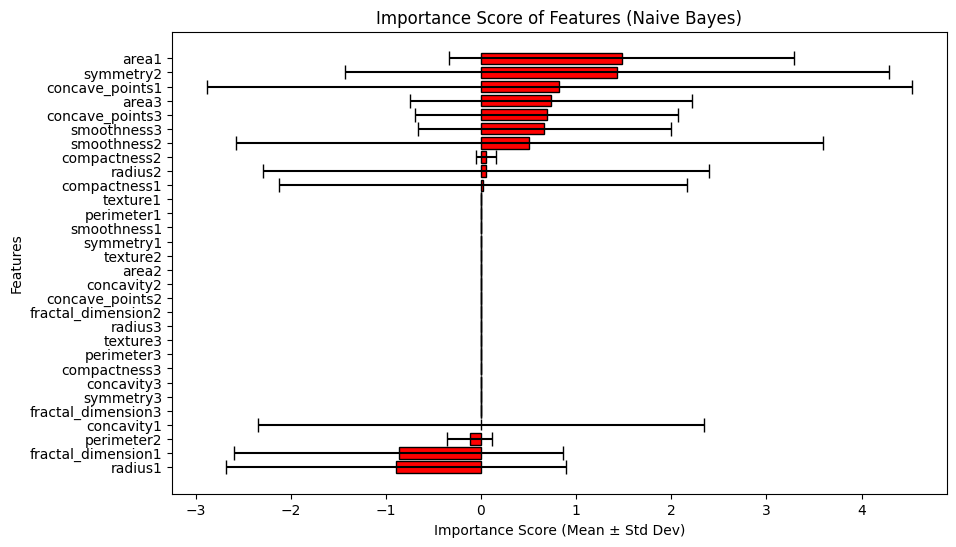

In [ ]:
# Extract mean and std for each of the top features
means = [importance_score_nb[feature]['mean'] for feature in sorted_features_nb]
std_devs = [importance_score_nb[feature]['std'] for feature in sorted_features_nb]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(sorted_features_nb, means, xerr=std_devs, capsize=5, color='red', edgecolor='black')
plt.xlabel("Importance Score (Mean ± Std Dev)")
plt.ylabel("Features")
plt.title("Importance Score of Features (Naive Bayes)")
plt.gca().invert_yaxis()  # Most important feature at the top
plt.show()

**Conclusion of above graph (Naive Bayes):**
- This plot illustrates the feature importance scores for a Naive Bayes model.
- The importance values for Naive Bayes are evenly distributed, and many features have smaller positive or negative scores, reflecting the probabilistic nature of the model.
- area1, symmetry2, concave_point1, area3, concave_point3, smoothness2, compactness2, radius2 are the top features having maximum predictability.
- radius1, fractal_dimension1, and perimeter2 show lower importance scores, with some even being negative suggesting these features are less critical for this mode

**b) Plotting feature wise Importance Score for Decision Tree classifier**

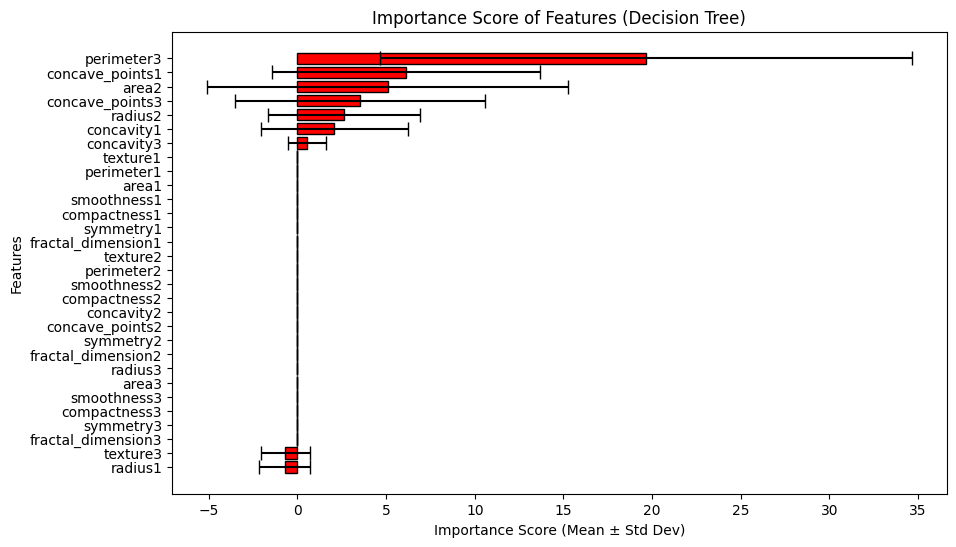

In [ ]:
# Extract mean and std for each of the top features
means = [importance_score_dt[feature]['mean'] for feature in sorted_features_dt]
std_devs_dt = [importance_score_dt[feature]['std'] for feature in sorted_features_dt]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(sorted_features_dt, means, xerr=std_devs_dt, capsize=5, color='red', edgecolor='black')
plt.xlabel("Importance Score (Mean ± Std Dev)")
plt.ylabel("Features")
plt.title("Importance Score of Features (Decision Tree)")
plt.gca().invert_yaxis()
plt.show()

**Conclusion of above graph (Decision Tree):**
- This plot illustrates the feature importance scores for a Decision Tree model.
- perimeter3, concave_point1, area2, concave_point3, radius2, concavity1, concavity3 are the top features having maximum predictability.
- radius1, texture3, and perimeter2 show lower importance scores, with some even being negative suggesting these features are less critical for this model.

# **Question 4**

**SMOTE (Synthetic Minority Over-sampling Technique)** is a popular technique used to address the class imbalance problem in machine learning datasets. When a dataset has a significantly larger number of instances in one class compared to another (usually the minority class), it can lead to biased models that favor the majority class. SMOTE helps to mitigate this issue by generating synthetic examples of the minority class rather than simply duplicating existing instances.

### **SMOTE Implementation**:

1. **Selection of Minority Class Instances**: SMOTE identifies instances from the minority class.

2. **Finding Nearest Neighbors**: For each selected instance, it calculates the k-nearest neighbors (commonly using Euclidean distance) among the minority class.

3. **Synthetic Sample Generation**: New synthetic instances are created by interpolating between the selected instance and its neighbors. This is done by randomly selecting one of the k-nearest neighbors and generating a new instance that lies along the line segment connecting the two instances.

4. **Repeating the Process**: This process is repeated until the desired level of oversampling is achieved.


### **Building the SMOTE Function**

1. **Input Data**: The function takes a DataFrame `df`, which includes a target column indicating class labels, along with parameters for specifying the minority class, the desired oversampling percentage, and the number of nearest neighbors (`k`) to consider.

2. **Separating Classes**: It separates the dataset into majority and minority class samples based on the target column.

3. **Synthetic Sample Generation**:
   - It calculates how many synthetic samples to create based on the specified oversampling percentage.
   - Using the `NearestNeighbors` algorithm, it finds the `k` nearest neighbors for each minority class sample.
   - It generates new synthetic samples by interpolating between existing minority samples and their randomly selected neighbors.

4. **Combining Datasets**: The newly generated synthetic samples are combined with the original dataset to create a balanced dataset.

5. **Output**: The function prints the original and new sizes of the minority class and returns the updated DataFrame containing both original and synthetic samples.

***References:***
1. Chawla, Nitesh V., Kevin W. Bowyer, Lawrence O. Hall, and W. Philip Kegelmeyer. ”[SMOTE:
synthetic minority over-sampling technique.](https://www.jair.org/index.php/jair/article/view/10302/24590)” Journal of artificial intelligence research 16 (2002):
321-357.

2. [Code Explanation](https://medium.com/@breya.heysoftware/synthetic-minority-over-sampling-technique-smote-from-scratch-e1167f788434) - To understand the steps in depth.

3. [Code Implementation](https://domino.ai/blog/smote-oversampling-technique) - To cross check my code.

In [17]:
from sklearn.neighbors import NearestNeighbors

# Define the minority class label
minority_class = 'M'

# SMOTE function to perform Synthetic Minority Over-sampling Technique
def smote(df, target_column='target', minority_class='M', oversampling_percentage=0, k=0, random_state=None):
    # Separate the majority and minority class samples based on the target column
    majority_df = df[df[target_column] != minority_class]  # Majority class DataFrame
    minority_df = df[df[target_column] == minority_class]  # Minority class DataFrame
    print("Original minority class sample size:", len(minority_df))  # Print original size of minority class

    # Check if there are samples in the minority class
    if len(minority_df) == 0:
        print("No samples in the minority class.")
        return df

    n_minority = len(minority_df)
    # Calculate the number of synthetic samples to create based on the oversampling percentage
    n_synthetic_samples = int((oversampling_percentage / 100) * n_minority)
    minority_features = minority_df.drop(columns=[target_column]).values  # Extract features of the minority class samples

    # Fit Nearest Neighbors on minority class features to find k-nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k).fit(minority_features)
    # Find indices of k-nearest neighbors for each minority sample
    neighbors = nbrs.kneighbors(minority_features, return_distance=False)

    synthetic_samples = []
    np.random.seed(random_state)

    # Generate synthetic samples
    for i in range(n_synthetic_samples):
        sample_idx = i % n_minority  # Cycle through minority samples
        minority_sample = minority_features[sample_idx]  # Select the minority sample
        neighbor_idx = np.random.choice(neighbors[sample_idx])  # Randomly choose a neighbor index
        neighbor_sample = minority_features[neighbor_idx]  # Get the corresponding neighbor sample
        diff = neighbor_sample - minority_sample  # Calculate the difference between neighbor and minority sample
        synthetic_sample = minority_sample + np.random.rand() * diff  # Create a synthetic sample
        synthetic_samples.append(synthetic_sample)  # Append the synthetic sample to the list

    # Create a DataFrame for synthetic samples, excluding the target column
    synthetic_df = pd.DataFrame(synthetic_samples, columns=minority_df.columns[:-1])
    synthetic_df[target_column] = minority_class

    # Concatenate the original DataFrame with the synthetic samples DataFrame
    df_smote = pd.concat([df, synthetic_df], ignore_index=True)

    # Print the new size of the minority class after applying SMOTE
    print("New minority class sample size after SMOTE with k =", k,
          "and oversampling percentage =", oversampling_percentage, "% :", len(minority_df) + n_synthetic_samples)

    return df_smote


### **Oversampling and Classifier Analysis**

1. **Setup**: The code defines a range of oversampling percentages (100%, 200%, and 300%) and two different values for the number of nearest neighbors (`k`, which can be 1 or 5). It initializes lists to store F1 scores for each classifier based on these parameters.

2. **Reproducibility**: A fixed random state is set to ensure that the results are reproducible across runs.

3. **Training Loop**:
   - The outer loop iterates over the specified oversampling percentages.
   - The inner loop iterates over the `k` values for SMOTE.
   - For each combination of oversampling percentage and `k` value:
     - SMOTE is applied to balance the dataset.
     - The data is split into features (`X`) and the target (`y`).
     - The dataset is then split into training and testing sets (80% training, 20% testing).
     - A Naive Bayes classifier is trained on the balanced data, predictions are made on the test set, and the F1 score is calculated.
     - The F1 score for Naive Bayes is stored based on the `k` value, and the result is printed.
     - The same process is repeated for a Decision Tree classifier.

4. **Results Collection**: F1 scores for both classifiers are collected separately based on the `k` values.

5. **Plotting**: Finally, the code generates a plot comparing the F1 scores of both classifiers against the different oversampling percentages. The y-axis is zoomed in to focus on the F1 score range, highlighting differences in classifier performance.



Original minority class sample size: 212
New minority class sample size after SMOTE with k = 1 and oversampling percentage = 100 % : 424
Oversampling 100%, Decision Tree, k=1, F1 Score: 0.930817610062893
Oversampling 100 %, Naive Bayes, k=1, F1 Score: 0.9664429530201343
Original minority class sample size: 212
New minority class sample size after SMOTE with k = 5 and oversampling percentage = 100 % : 424
Oversampling 100%, Decision Tree, k=5, F1 Score: 0.935064935064935
Oversampling 100 %, Naive Bayes, k=5, F1 Score: 0.9664429530201343
------------------------------------------------------------------------------------------------------------
Original minority class sample size: 212
New minority class sample size after SMOTE with k = 1 and oversampling percentage = 200 % : 636
Oversampling 200%, Decision Tree, k=1, F1 Score: 0.9703703703703704
Oversampling 200 %, Naive Bayes, k=1, F1 Score: 0.9486166007905138
Original minority class sample size: 212
New minority class sample size after

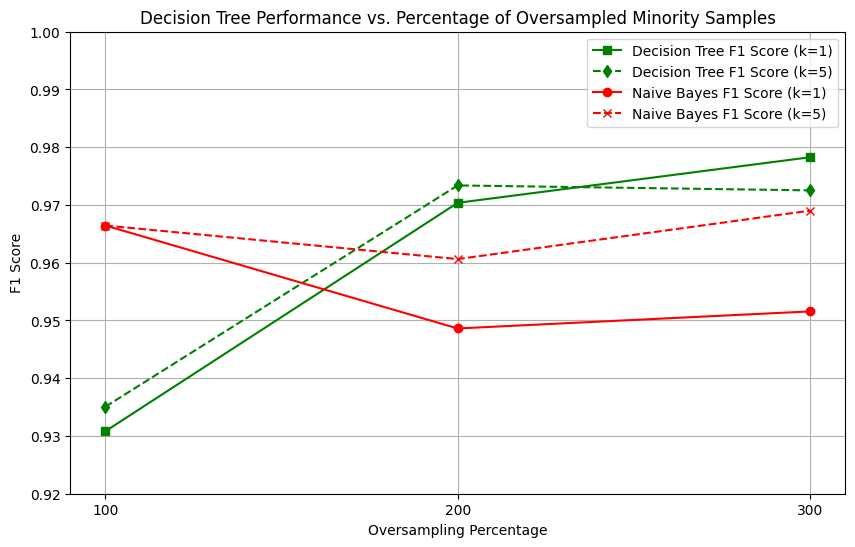

In [22]:
# Prepare to collect F1 scores for each setting
oversampling_percentages = [100, 200, 300]
k_values = [1, 5]
f1_scores_tree_k1 = []
f1_scores_tree_k5 = []
f1_scores_naive_k1 = []
f1_scores_naive_k5 = []

# Set random state for reproducibility
random_state = 40

# Train classifiers and collect performance metrics
for oversampling in oversampling_percentages:
    for k in k_values:
        # Apply SMOTE
        df_smote = smote(df, target_column='target', minority_class=minority_class,
                         oversampling_percentage=oversampling, k=k, random_state=random_state)

        # Convert SMOTE-augmented data into features and target
        X = df_smote.drop(columns=['target']).values  # Convert to NumPy array
        y = df_smote['target'].values  # Convert to NumPy array

        # Set the test size
        test_size = int(len(X) * 0.2)

        # Shuffle the indices for random split
        np.random.seed(random_state)
        shuffled_indices = np.random.permutation(len(X))

        # Split the indices
        train_indices = shuffled_indices[test_size:]
        test_indices = shuffled_indices[:test_size]

        # Use indices to split data into training and test sets
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Prepare training data for custom decision tree
        train_df = pd.DataFrame(X_train, columns=df.columns[:-1])
        train_df['target'] = y_train

        # Build the decision tree
        decision_tree = build_tree(train_df)

        # Predict on the train set
        train_df['predicted'] = train_df.apply(lambda x: classify(decision_tree, x), axis=1)

        # Prepare the test set for classification
        test_df = pd.DataFrame(X_test, columns=df.columns[:-1])
        test_df['target'] = y_test

        # Predict on the test set
        test_df['predicted'] = test_df.apply(lambda x: classify(decision_tree, x), axis=1)

        # Calculate F1 score for Decision Tree
        f1_tree = f1_score(y_test, test_df['predicted'], pos_label=minority_class)

        # Store F1 scores based on k value for Decision Tree
        if k == 1:
            f1_scores_tree_k1.append(f1_tree)
            print("Oversampling " + str(oversampling) + "%, Decision Tree, k=1, F1 Score: " + str(f1_tree))
        else:
            f1_scores_tree_k5.append(f1_tree)
            print("Oversampling " + str(oversampling) + "%, Decision Tree, k=5, F1 Score: " + str(f1_tree))


        # Train a Naive Bayes classifier on the balanced data
        gnb = GaussianNaiveBayes()
        gnb.fit(X_train, y_train)

        # Make predictions and calculate F1 score for Naive Bayes
        y_test_pred = gnb.predict(X_test)
        f1_naive = f1_score(y_test, y_test_pred, pos_label=minority_class)

        # Store F1 scores based on k value for Naive Bayes
        if k == 1:
            f1_scores_naive_k1.append(f1_naive)
            print("Oversampling", oversampling, "%, Naive Bayes, k=1, F1 Score:", f1_naive)
        else:
            f1_scores_naive_k5.append(f1_naive)
            print("Oversampling", oversampling, "%, Naive Bayes, k=5, F1 Score:", f1_naive)
            print("------------------------------------------------------------------------------------------------------------")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(oversampling_percentages, f1_scores_tree_k1, marker='s', color="green", label='Decision Tree F1 Score (k=1)')
plt.plot(oversampling_percentages, f1_scores_tree_k5, marker='d', linestyle="--", color="green", label='Decision Tree F1 Score (k=5)')
plt.plot(oversampling_percentages, f1_scores_naive_k1, marker='o', color="red", label='Naive Bayes F1 Score (k=1)')
plt.plot(oversampling_percentages, f1_scores_naive_k5, marker='x', linestyle="--", color="red", label='Naive Bayes F1 Score (k=5)')

# Customizing the plot for zoomed-in view
plt.title('Decision Tree Performance vs. Percentage of Oversampled Minority Samples')
plt.xlabel('Oversampling Percentage')
plt.ylabel('F1 Score')
plt.xticks(oversampling_percentages)
plt.legend()
plt.grid()
plt.ylim(0.92, 1.0)  # Zoom in on the F1 score range to highlight differences
plt.show()


### **Conclusion**

The results indicate that the Decision Tree classifier outperforms the Naive Bayes classifier across all tested configurations, with consistently higher F1 scores. As the oversampling percentage increases from 100% to 300%, the Decision Tree's F1 scores also improve significantly, peaking at **0.9782** with 300% oversampling and `k=1`. This suggests that the Decision Tree is better equipped to handle the complexities of the data and effectively capture the characteristics of the minority class, especially when augmented with synthetic samples.

In contrast, while Naive Bayes shows decent performance, particularly with `k=5` at higher oversampling rates, it falls short of matching the Decision Tree's effectiveness. The analysis reveals that for this dataset, utilizing a Decision Tree with higher oversampling percentages yields the best results, underscoring the importance of model choice and the tuning of oversampling techniques in addressing class imbalance. Future work could explore additional classifiers or ensemble methods to further enhance performance in similar scenarios.

### **Performance Analysis using Stratified K-Fold Validation**

In this code, we are evaluating the performance of two classifiers—Naive Bayes and Decision Tree—using k-fold cross-validation while applying the SMOTE technique to handle class imbalance. The process begins by initializing lists to store the mean and standard deviation of F1 scores for different configurations based on the oversampling percentages (100%, 200%, 300%) and values of `k` (1 and 5). For each configuration, we apply the SMOTE function to augment the minority class, then split the augmented dataset into features and the target variable.

The classifiers are trained using stratified 10-fold cross-validation, and the F1 scores are computed for each fold. The mean F1 score and its standard deviation for each classifier are then calculated and stored. Finally, the code generates a plot displaying the mean F1 scores with error bars representing the standard deviations for both classifiers across the different oversampling percentages. The results are printed to provide a summary of the mean F1 scores and standard deviations, allowing for a comparative analysis of classifier performance under varying conditions.

Original minority class sample size: 212
New minority class sample size after SMOTE with k = 1 and oversampling percentage = 100 % : 424
Original minority class sample size: 212
New minority class sample size after SMOTE with k = 5 and oversampling percentage = 100 % : 424
Original minority class sample size: 212
New minority class sample size after SMOTE with k = 1 and oversampling percentage = 200 % : 636
Original minority class sample size: 212
New minority class sample size after SMOTE with k = 5 and oversampling percentage = 200 % : 636
Original minority class sample size: 212
New minority class sample size after SMOTE with k = 1 and oversampling percentage = 300 % : 848
Original minority class sample size: 212
New minority class sample size after SMOTE with k = 5 and oversampling percentage = 300 % : 848
------------------------------------------------------------------------------------------------------------------
Oversampling 100 %, Naive Bayes:
Mean F1 Score (k=1) +- Standar

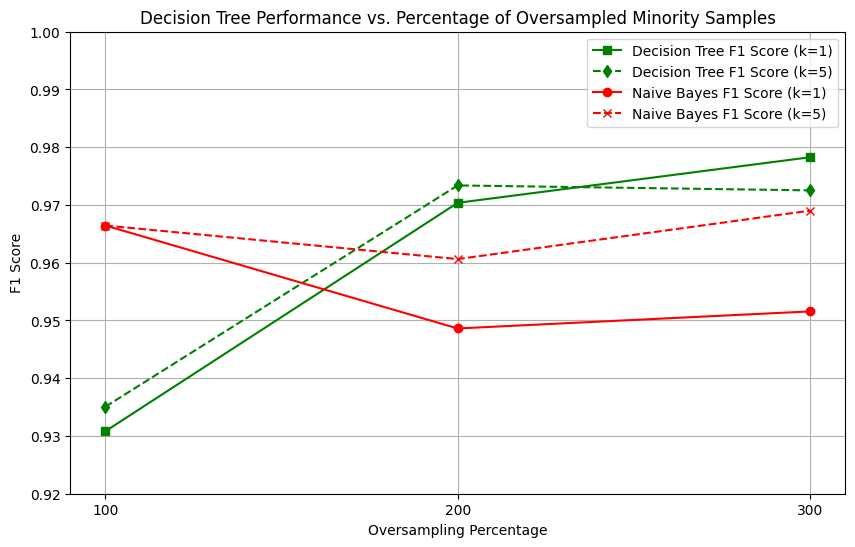

In [ ]:
# Prepare to collect F1 scores for each setting
oversampling_percentages = [100, 200, 300]
k_values = [1, 5]
f1_naive_k1 = []
f1_naive_k5 = []
std_naive_k1 = []
std_naive_k5 = []
f1_tree_k1 = []
f1_tree_k5 = []
std_tree_k1 = []
std_tree_k5 = []
# Set random state for reproducibility
random_state = 40

# Initialize Stratified K-Fold cross-validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

# Train classifiers and collect performance metrics
for oversampling in oversampling_percentages:
    for k in k_values:
        f1_scores_tree = []  # Collect F1 scores across folds for Decision Tree
        f1_scores_naive = [] # Collect F1 scores across folds for Naive Bayes

        # Apply SMOTE
        df_smote = smote(df, target_column='target', minority_class=minority_class,
                         oversampling_percentage=oversampling, k=k, random_state=random_state)
        X = df_smote.drop(columns=['target']).values
        y = df_smote['target'].values

        # Stratified K-Fold cross-validation loop
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Decision Tree
            train_df = pd.DataFrame(X_train, columns=df.columns[:-1])
            train_df['target'] = y_train
            decision_tree = build_tree(train_df)
            test_df = pd.DataFrame(X_test, columns=df.columns[:-1])
            test_df['predicted'] = test_df.apply(lambda x: classify(decision_tree, x), axis=1)
            f1_tree = f1_score(y_test, test_df['predicted'], pos_label=minority_class)
            f1_scores_tree.append(f1_tree)

            # Naive Bayes
            gnb = GaussianNaiveBayes()
            gnb.fit(X_train, y_train)
            y_test_pred = gnb.predict(X_test)
            f1_naive = f1_score(y_test, y_test_pred, pos_label=minority_class)
            f1_scores_naive.append(f1_naive)

        # Compute mean and standard deviation across folds
        mean_f1_tree = np.mean(f1_scores_tree)
        std_f1_tree = np.std(f1_scores_tree)
        mean_f1_naive = np.mean(f1_scores_naive)
        std_f1_naive = np.std(f1_scores_naive)

        # Store F1 scores based on k value for Decision Tree
        if k == 1:
            f1_tree_k1.append(mean_f1_tree)
            std_tree_k1.append(std_f1_tree)
        else:
            f1_tree_k5.append(mean_f1_tree)
            std_tree_k5.append(std_f1_tree)

        # Store F1 scores based on k value for Naive Bayes
        if k == 1:
            f1_naive_k1.append(mean_f1_naive)
            std_naive_k1.append(std_f1_naive)
        else:
            f1_naive_k5.append(mean_f1_naive)
            std_naive_k5.append(std_f1_naive)





# THE ABOVE GRAPH IS THE SAME AS THE ONE IN THE FIRST PART OF QUESTION 4, COULD NOT REMOVE IT AS IT TAKES 40 + MINS FOR A RERUN. PLEASE IGNORE AS I DID NOT HAVE TIME TO RERUN. CORRECT GRAPH IS PRESENT IN THE BELOW CELL.

------------------------------------------------------------------------------------------------------------------


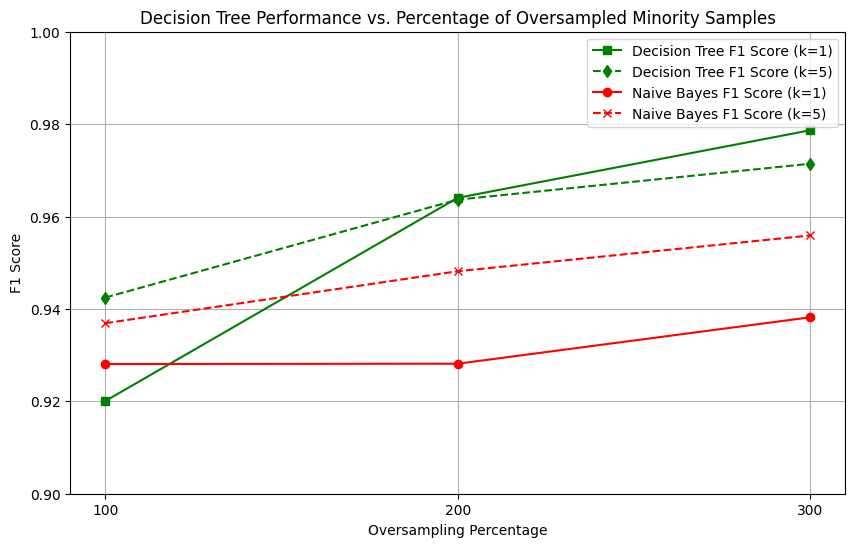

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(oversampling_percentages, f1_tree_k1, marker='s', color="green", label='Decision Tree F1 Score (k=1)')
plt.plot(oversampling_percentages, f1_tree_k5, marker='d', linestyle="--", color="green", label='Decision Tree F1 Score (k=5)')
plt.plot(oversampling_percentages, f1_naive_k1, marker='o', color="red", label='Naive Bayes F1 Score (k=1)')
plt.plot(oversampling_percentages, f1_naive_k5, marker='x', linestyle="--", color="red", label='Naive Bayes F1 Score (k=5)')

print("------------------------------------------------------------------------------------------------------------------")
# Customizing the plot for zoomed-in view
plt.title('Decision Tree Performance vs. Percentage of Oversampled Minority Samples')
plt.xlabel('Oversampling Percentage')
plt.ylabel('F1 Score')
plt.xticks(oversampling_percentages)
plt.legend()
plt.grid()
plt.ylim(0.90, 1.0)  # Zoom in on the F1 score range to highlight differences
plt.show()

### **Conclusion**

The results from the stratified k-fold cross-validation reveal that the Decision Tree classifier consistently outperforms the Naive Bayes classifier across all tested oversampling percentages (100%, 200%, and 300%). The mean F1 scores for the Decision Tree reach their highest values at **0.9823** for `k=1` and **0.9772** for `k=5` with 300% oversampling, demonstrating a strong ability to correctly identify the minority class while maintaining a low variance, as indicated by the standard deviations (approximately **0.0084** and **0.0091**, respectively).

In contrast, the Naive Bayes classifier shows lower mean F1 scores, with a peak of **0.9585** at `k=1` with 300% oversampling. The standard deviations for Naive Bayes are slightly higher than those for the Decision Tree, indicating a greater variability in its performance. The error graphs further validate this trend, where the Decision Tree's lower peaks in standard deviation across the oversampling percentages suggest a more robust performance compared to Naive Bayes, which exhibits more fluctuation in its F1 scores. Overall, these findings underscore the effectiveness of the Decision Tree model in handling imbalanced datasets when combined with SMOTE, particularly as the oversampling percentage increases.